In [ ]:
!pip uninstall tensorflow

Uninstalling tensorflow-2.3.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.3.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.3.0


In [ ]:
!pip install tensorflow==1.13.2

     |████████████████████████████████| 92.6MB 67kB/s 
     |████████████████████████████████| 368kB 39.0MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 3.2MB 40.7MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/CCTV_Model

/content/drive/MyDrive/CCTV_Model


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sklearn.metrics as metrics
import tensorflow as tf
import pickle
import pandas as pd
import matplotlib.image as mpimg
from network import *
from loader import *
import glob
from utility_functions import *

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
ph = tf.placeholder('float', [None, None])

In [ ]:
output , parameters_1 , parameters_2, parameters_3 = define_network(ph)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.


In [ ]:
# Initialize and run
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [ ]:
saved_model_loader = tf.train.Saver()  # to load model

In [ ]:
saved_model_loader.restore(sess, './model/model')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model/model


In [ ]:
def detect_anomaly(input_video):
    model_output = sess.run(output,feed_dict={ph: input_video})
    model_output = model_output.flatten()
     # if anomaly score is greater then 0.4 then consider as anomaly 
    frame = np.where(model_output>0.4)[0]
    prediction=0
    if model_output.max() > 0.4:
        prediction=1
    return prediction, frame
    

## this section generates data for further classification of video in to (fighting/accident)

In [ ]:
data_path_abnormal ="./data"
anomalous_videos = fetch_videos("./data"+"/anomaly.txt")


In [ ]:
class_videos=[]
prediction =[] # prediction only for anomaly detection
anomalous_frames=[]

#video_class
for i in range(len(anomalous_videos)):
    
    video_path=os.path.join(data_path_abnormal,anomalous_videos[i] )
    
    with open(video_path,'r') as file:
        lines = file.read().splitlines()
        key=os.path.basename(anomalous_videos[i])
        key=os.path.splitext(key)[0]
        
        if "Fighting" in key: # this is for further classification using DNN
            class_videos.append(1)
        elif "Road" in key:
            class_videos.append(0)
            
        features=[]
    
    for line in lines:
        features.append(np.float32(line.split()))
    
    anomalous, anomaly_location = detect_anomaly(features)
    
    prediction.append(anomalous)
    anomalous_frames.append(anomaly_location)

In [ ]:
data_set = open("data.pkl","wb")
pickle.dump({"File_location":anomalous_videos, "Anomaly_type":class_videos, "anomaly_frames":anomalous_frames}, data_set)

### Anomaly type menas (1:Fighting / 0: Accident) AnomalyFrame contains frame no where anomaly occured. 

### This Data Set is used for further anomaly type classification 

In [ ]:
pd.DataFrame(zip(anomalous_videos,class_videos,anomalous_frames),columns=['File_location', 'Anomaly_type', 'Anomaly_frame'])

,File_location,Anomaly_type,Anomaly_frame
0,Anomaly-Videos-Part-2/Fighting/Fighting002_x26...,1,[]
1,Anomaly-Videos-Part-2/Fighting/Fighting003_x26...,1,[]
2,Anomaly-Videos-Part-2/Fighting/Fighting004_x26...,1,[]
3,Anomaly-Videos-Part-2/Fighting/Fighting005_x26...,1,[]
4,Anomaly-Videos-Part-2/Fighting/Fighting006_x26...,1,[]
...,...,...,...
171,Anomaly-Videos-Part-3/RoadAccidents/RoadAccide...,0,"[0, 1, 2, 3, 4]"
172,Anomaly-Videos-Part-3/RoadAccidents/RoadAccide...,0,"[1, 2, 3, 6, 7, 8, 10]"
173,Anomaly-Videos-Part-3/RoadAccidents/RoadAccide...,0,"[4, 5, 6]"
174,Anomaly-Videos-Part-3/RoadAccidents/RoadAccide...,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14]"


In [ ]:
data_path_normal="./data"
normal_videos = fetch_videos("./data"+"/anomaly.txt")

In [ ]:
predictions=[]
for i in range(len(normal_videos)):
    video_path=os.path.join(data_path_normal,normal_videos[i] )
    
    with open(video_path,'r') as file:
        lines = file.read().splitlines()
    features=[]
    
    for line in lines:
        features.append(np.float32(line.split()))
        
    model_output, _ =detect_anomaly(features)
    
    predictions.append(model_output)
    

In [ ]:
true_positives=np.array([1]*176)
true_negatives=np.array([0]*176)

In [ ]:
actual=np.hstack((true_positives,true_negatives))

In [ ]:
final_predictions=np.hstack((np.array(prediction),np.array(predictions)))

In [ ]:
false_positive_rate, true_positive_rate, threshold = metrics.roc_curve(actual, final_predictions)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

In [ ]:
metrics.confusion_matrix(actual,final_predictions)

array([[ 76, 100],
       [ 76, 100]])

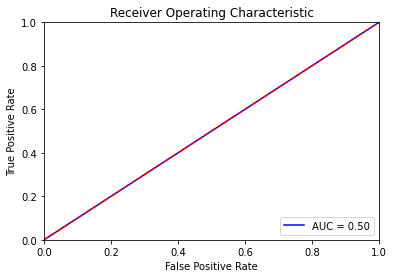

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Video Visualization

In [ ]:
def detect_anomalous_segment(input_video,input_video_name):
    max_processing_sec = 599
    frame_increase=16
    num_frames = 16
    start_frame = 1
    
    frame_count,frame_rate=count_frames(input_video)
    
    end_frame = min(frame_count, int(max_processing_sec * frame_rate)) -num_frames
    
    features = extract_video_features(input_video_name,"./data")
    model_output=sess.run(output,feed_dict={ph: features})
    
    start_frames=list(range(start_frame, end_frame, frame_increase))
    
    frame_bin=np.round(np.linspace(1, len(start_frames), num=33))
    
    model_output=model_output.flatten()
    predicted=np.where(model_output>0.4)[0]
    
    video_segments=[]
    i=0

    
    while(i<len(predicted)-1):
        segment_start=frame_bin[predicted[i]]*16
        if (predicted[i+1] - predicted[i] ==1):
            while(i<len(predicted)-1 and predicted[i+1]-predicted[i]==1):
                i +=1
            segment_end=frame_bin[predicted[i]]*16+16
        else:
            i += 1
            segment_end=segment_start+16
        video_segments.append([segment_start,segment_end])
        
    video_map=frame_bin[predicted]*16
    return video_segments,video_map,model_output 

In [ ]:
def get_anomalous_segment_from_video(input_video,input_video_name,output_dir):
    video_segments, video_map, model_output=detect_anomalous_segment(input_video,input_video_name)
    
    #path to store Video segment
    path = os.path.join(output_dir,input_video_name)
    os.makedirs(path, exist_ok=True)
    
    for start, end in video_segments:
        num_frames = int(end-start)
        get_video_frames(input_video,start,path,num_frames)
     
    output_video=os.path.join(path,input_video_name)
    if len(video_segments)>0:
        generate_video_from_image(path,output_video+".avi")
    
    return video_map, model_output

## generating video for RoadAccident 

## This solution also includes video and images where exact anomaly happened 

In [ ]:
input_video_path="/content/Fighting004_x264.mp4"
anomalous_frames, model_output=get_anomalous_segment_from_video(input_video_path,"RoadAccidents095_x264","./frames")

Text(0.5, 0, 'Prediction in 32 embedded frames')

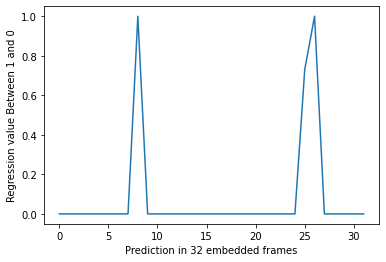

In [ ]:
plt.plot(model_output)
plt.ylabel('Regression value Between 1 and 0')
plt.xlabel('Prediction in 32 embedded frames')

### The plot above shows anomaly in video so what are the frames where anomaly occured

# generating video for fight

In [ ]:
input_video_path="/content/Fighting004_x264.mp4"
anomalous_frames, model_output=get_anomalous_segment_from_video(input_video_path,"Fighting032_x264","./frames")

Text(0.5, 0, 'Prediction in 32 embedded frames')

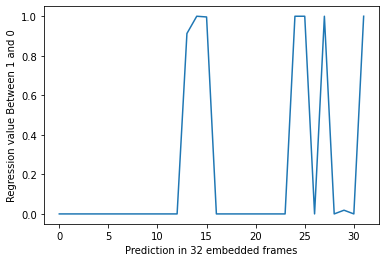

In [ ]:
plt.plot(model_output)
plt.ylabel('Regression value Between 1 and 0')
plt.xlabel('Prediction in 32 embedded frames')

## Normal Videos are predicted as 0 

## Some Testing examples

In [ ]:
normal_features = get_test_data_normal() # load test data set is some  just test normal videos 

In [ ]:
print(normal_features.shape) 

(4320, 4096)


In [ ]:
model_output = sess.run(output,feed_dict={ph: normal_features})

In [ ]:
model_output=model_output.flatten()

In [ ]:
false_predictions=(model_output>0.4).sum()

### Total 4320 normal frames 

# False Positive rate

In [ ]:
false_positive_rate=false_predictions/normal_features.shape[0]

In [ ]:
print(false_positive_rate)

0.09745370370370371
